In [15]:
%matplotlib inline
import os
import json
from pprint import pprint
import matplotlib.pyplot as plt

from twython import TwythonStreamer
from collections import Counter

import string
import nltk

from wordcloud import WordCloud
from textblob import TextBlob
from statistics import mean 

In [16]:
# Set trans table for NLP
puncs = string.punctuation
dgts = string.digits
table_p = str.maketrans(puncs, len(puncs) * " ")

# Create stopword Dict
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('rt')
stopwords.append('https')

In [17]:
# Import Gene's TwythonStreamer 

# Acknowledgement: This code is adopted from the book "Data Science from Scratch"
# https://github.com/joelgrus/data-science-from-scratch/tree/master/first-edition
class MyStreamer(TwythonStreamer):

    # by default, this module will collect 1000 tweets
    target_tweet_count = 1000
    
    # overriding
    def on_success(self, data):
        if 'text' in data:      # check if the received data has key 'text'
            tweets.append(data) # append data to our list
            
        if len(tweets) % 100 == 1:
            print('\nNow we collected {} tweets!'.format(len(tweets)))
            print(len(tweets), data['text'])    # print the tweet text

        if len(tweets) >= self.target_tweet_count:  # if we have 1000 tweets
            self.disconnect()   # disconnect API connection using a method from TwythonStreamer

    # overriding
    def on_error(self, status_code, data):
        print(status_code)
        self.disconnect()

# global list to collect the tweets
tweets = []       

def collect_tweets(stream, keyword, count):
    global tweets
    tweets = [] # re-initialize tweets list
    stream.target_tweet_count = count
    stream.statuses.filter(track=keyword)
    return tweets


## Create Stream

In [18]:
#Import credentials from env vars
consumer_key = str(os.environ['twit_consumer_key'])
consumer_secret = str(os.environ['twit_consumer_secret'])
access_token = str(os.environ['twit_access_token'])
access_token_secret = str(os.environ['twit_access_token_secret'])

In [19]:
#Create Stream
stream = MyStreamer(consumer_key, consumer_secret, access_token, access_token_secret)
print(stream)

In [20]:
# keyword = 'Boris Johnson'
# #keyword = ''
# print('My keywords is ' + keyword)

In [21]:
# start collecting 5000 tweets with keyword
# tweets = collect_tweets(stream, keyword, 5000)
# print(len(tweets), 'tweets are collected')

In [22]:
# with open('tweet_stream_{}_{}.json'.format(keyword, len(tweets)), 'w') as outfile:
#     json.dump(tweets, outfile, indent=4)

In [23]:
keyword = 'Brexit'
#keyword = ''
print('My keywords is ' + keyword)

My keywords is Brexit


In [24]:
# # start collecting 5000 tweets with keyword
#  tweets = collect_tweets(stream, keyword, 5000)
# print(len(tweets), 'tweets are collected')

In [25]:
# with open('tweet_stream_{}_{}.json'.format(keyword, len(tweets)), 'w') as outfile:
#     json.dump(tweets, outfile, indent=4)

In [26]:
# Open files 
with open('tweet_stream_Brexit_5000.json') as infile:
    brex_data = json.load(infile)
    
with open('tweet_stream_Boris Johnson_5000.json') as infile:
    bj_data = json.load(infile)

# Put both datsets into a list for easier handling
data = {'brex_data' : brex_data, 'bj_data' : bj_data}

### Most popular words with and without stopwords

Structure taken from https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json

In [27]:
# Test data set
test = data['brex_data'][:50]

### Tweet Parser
This will parse each tweet and check if it is a quote, retweet, or just a regular tweet.  It will also check to see the status of the relevant text section to see if it is truncated.  If so it will fetch the extended.  Finally it will put all the strings into a list of lists.

In [28]:
def tweet_text_parse(tweet_json,tweet_list):
    """
    Takes in a twitter API JSON file and an empty list, then finds the longest version of the retweet, 
    quote, and regular text file.  It will then remove any duplicates among the three and then append
    the results to the list.
    """
    for count, x in enumerate(tweet_json):
        #Reset Variables
        quote = ''
        rt = ''
        text = ''

        # Check if this tweet is a quote
        # some tweets include is_quote_status but not quoted_status
        if 'is_quote_status' and 'quoted_status' in x.keys():
                if x['quoted_status']['truncated']:
                    quote = (x['quoted_status']['extended_tweet']['full_text'])
                else:
                    quote = (x['quoted_status']['text'])

        # Check if this tweet is a RT
        if 'retweeted_status' in x.keys():
            if x['retweeted_status']['truncated']:
                rt = (x['retweeted_status']['extended_tweet']['full_text'])
            else:
                rt = (x['retweeted_status']['text'])
        if x['truncated']:
            text = (x['extended_tweet']['full_text'])
        else:
            text = (x['text'])

        # Remote Duplicate Text
        if quote in text:
            quote = ''
        if rt in text:
            rt = ''
        tweet_list.append([quote]+[rt]+[text])

### Parse JSON Files and store them as lists of lists

In [29]:
tweet_list_brexit = []
tweet_list_boris_johnson = []

tweet_text_parse(data['brex_data'],tweet_list_brexit)
tweet_text_parse(data['bj_data'],tweet_list_boris_johnson)

### Split the lists of lists into a list of individual words

In [30]:
brexit_words =[]
brexit_stopwords = []

for tweet in tweet_list_brexit:
    for text in tweet:
        brexit_words += text.lower().split()

for words in brexit_words:
    if words not in stopwords and len(words) > 1:
        brexit_stopwords.append(words)

In [31]:
bj_words =[]
bj_stopwords = []

for tweet in tweet_list_boris_johnson:
    for text in tweet:
        bj_words += text.lower().split()

for words in bj_words:
    if words not in stopwords and len(words) > 1:
        bj_stopwords.append(words)

### Word frequency 

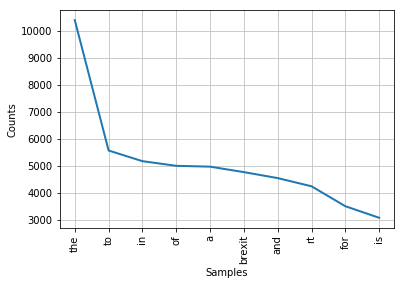

In [32]:
# Brexit word frequency
freq = nltk.FreqDist(brexit_words)
freq.plot(10)

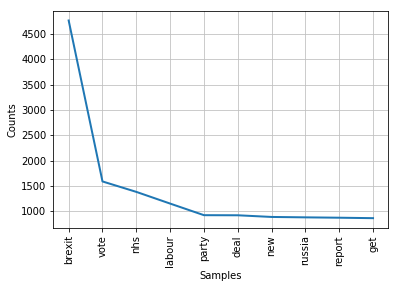

In [33]:
# Brexit word frequency without stopwords
freq = nltk.FreqDist(brexit_stopwords)
freq.plot(10)

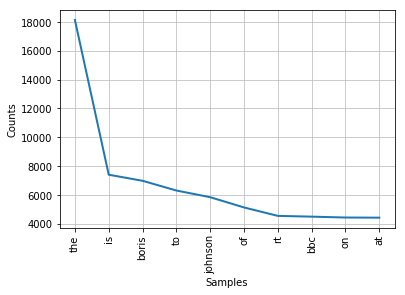

In [34]:
# Boris Johnson word frequency with stopwords
freq = nltk.FreqDist(bj_words)
freq.plot(10)

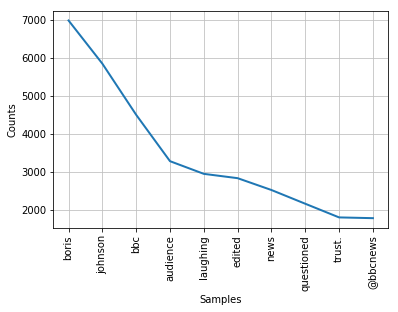

In [35]:
# Boris Johnson word frequency without stopwords
freq = nltk.FreqDist(bj_stopwords)
freq.plot(10)

### Hashtags + Mentions

In [36]:
brexit_hashtag_count = []
brexit_mention_list = []
for x, y in enumerate(data['brex_data']):
    hashtag = data['brex_data'][x]['entities']['hashtags']
    if len(hashtag) > 0:
        brexit_hashtag_count.append(hashtag[0]['text'])
    mentions = data['brex_data'][x]['entities']['user_mentions']
    for ment in mentions:
        brexit_mention_list.append(ment['screen_name'])


bj_hashtag_count = []
bj_mention_list =[] 
for x, y in enumerate(data['bj_data']):
    hashtag = data['bj_data'][x]['entities']['hashtags']
    if len(hashtag) > 0:
        bj_hashtag_count.append(hashtag[0]['text'])
    mentions = data['bj_data'][x]['entities']['user_mentions']
    for ment in mentions:
        bj_mention_list.append(ment['screen_name'])

### Brexit Hashtags

In [37]:
ht = Counter(brexit_hashtag_count)
ht.most_common(10)

[('Brexit', 105),
 ('brexit', 35),
 ('GE2019', 22),
 ('GetBrexitDone', 21),
 ('JeremyCorbyn', 16),
 ('Remain', 16),
 ('StopBrexit', 15),
 ('Russia', 13),
 ('CostOfCorbyn', 11),
 ('bbcqt', 11)]

### Boris Johnson Hashtags

In [38]:
htbj = Counter(bj_hashtag_count)
htbj.most_common(10)

[('bbcqt', 233),
 ('GE2019', 36),
 ('Exeter', 34),
 ('GTTO', 27),
 ('ge2019', 24),
 ('WASPI', 20),
 ('GetJohnsonOut', 19),
 ('FactCheckuk', 17),
 ('BigBrother', 10),
 ('NHSNotforSale', 10)]

### Brexit Mentions

In [39]:
b = Counter(brexit_mention_list)
b.most_common(10)

[('davidschneider', 478),
 ('OwenJones84', 177),
 ('LibDems', 140),
 ('NHSMillion', 133),
 ('mikegalsworthy', 127),
 ('Conservatives', 96),
 ('jeremycorbyn', 91),
 ('UKLabour', 88),
 ('BorisJohnson', 86),
 ('nickreeves9876', 80)]

### Boris Johnson Mentions

In [40]:
bj = Counter(bj_mention_list)
bj.most_common(10)

[('BBCNews', 594),
 ('OwenJones84', 510),
 ('AaronBastani', 349),
 ('ToryFibs', 282),
 ('OborneTweets', 275),
 ('jeremycorbyn', 174),
 ('NickFlaks', 161),
 ('CorbynistaTeen', 116),
 ('FullFact', 108),
 ('Rachael_Swindon', 106)]

In [41]:
person_score_brex = dict()

for tweet in data['brex_data']:
    person_id = tweet['user']['screen_name']
    follower_count = tweet['user']['followers_count']
    friend_count = tweet['user']['friends_count']
    favourites_count = tweet['user']['favourites_count']
    person_score_brex[person_id] = follower_count + friend_count + favourites_count

person_score_bj = dict()

for tweet in data['bj_data']:
    person_id = tweet['user']['screen_name']
    follower_count = tweet['user']['followers_count']
    friend_count = tweet['user']['friends_count']
    favourites_count = tweet['user']['favourites_count']
    person_score_bj[person_id] = follower_count + friend_count + favourites_count

### Most influential Brexit

In [42]:
c = Counter(person_score_brex)
c.most_common(10)

[('BBCNews', 10306601),
 ('SkyNews', 5276445),
 ('Independent', 2938204),
 ('segmentis', 930221),
 ('IsidorMeyer1', 832919),
 ('NHSMillion', 812662),
 ('BBCPolitics', 618339),
 ('LouisianaBernie', 572915),
 ('itsWanda', 548146),
 ('biffrbear', 524863)]

### Most influential Boris Johnson

In [43]:
c = Counter(person_score_bj)
c.most_common(10)

[('OwenJones84', 928513),
 ('Vilinthril', 847321),
 ('r0g3rd4y', 661582),
 ('MargyMayell', 634923),
 ('LAussieinNY', 618965),
 ('SophiaCannon', 588295),
 ('mckinlay_liz', 531675),
 ('magicdmw', 483340),
 ('porridgeisgood', 470704),
 ('Allchanges', 468250)]

### Parser to collect tweet count

In [66]:
tweet_count_brex = {}
for tweet in data['brex_data']:
    person_id = tweet['user']['screen_name']
    if person_id not in tweet_count_brex.keys():
        tweet_count_brex[person_id] = 1
    else:
        tweet_count_brex[person_id] += 1

tweet_count_bj = {}
for tweet in data['bj_data']:
    person_id = tweet['user']['screen_name']
    if person_id not in tweet_count_bj.keys():
        tweet_count_bj[person_id] = 1
    else:
        tweet_count_bj[person_id] += 1

### Most common Tweets about Brexit

In [68]:
c = Counter(tweet_count_brex)
c.most_common(10)

[('Webberc5Webber', 15),
 ('caroline353353', 13),
 ('solange_lebourg', 12),
 ('SandraDunn1955', 11),
 ('piyakhanna', 11),
 ('Freshdic', 11),
 ('AnnaAnnaou', 10),
 ('TheStephenRalph', 10),
 ('marshall_proEU', 9),
 ('Spencer_Hagard', 9)]

### Most common Tweeters about Boris Johnson

In [67]:
c = Counter(tweet_count_bj)
c.most_common(10)

[('j_sutherland2', 18),
 ('64e104205fc34a0', 14),
 ('Since_May68', 13),
 ('thatoneguy2440', 13),
 ('TheresiaGoodger', 13),
 ('oakleighRover', 11),
 ('Shambles151', 10),
 ('JFCWindmill', 10),
 ('woodenfishjim', 10),
 ('Decdently_sweet', 9)]

# Word Clouds

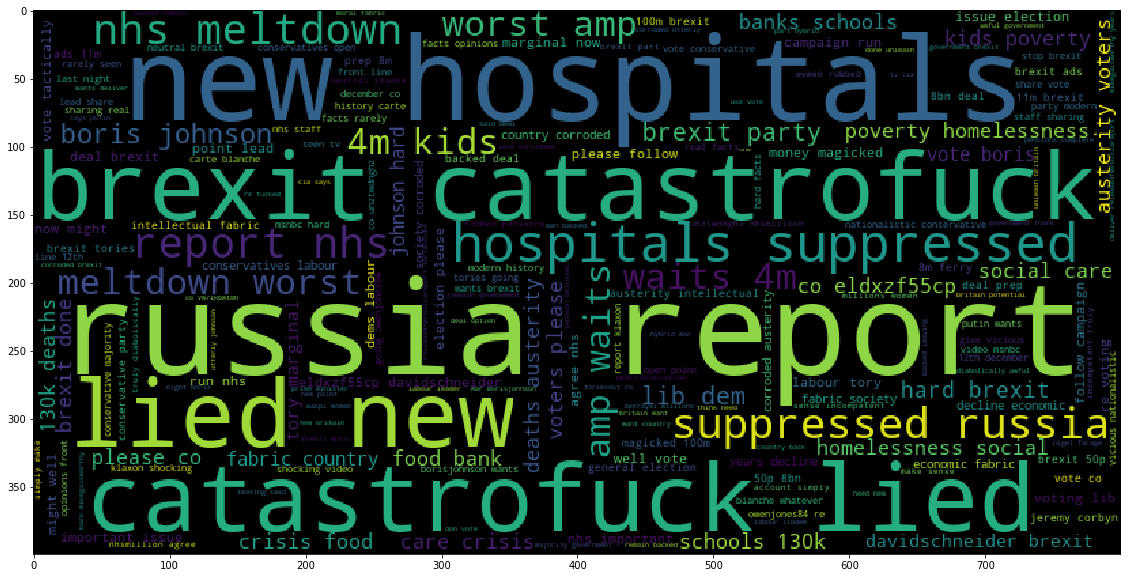

In [47]:
separator = " "
brexit_wordcloud = separator.join(brexit_stopwords)
brexit_wordcloud = brexit_wordcloud.replace('https',"")
# lower max_font_size
wordcloud = WordCloud(width=800, height=400).generate(brexit_wordcloud.translate(table_p)) 

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("on")
plt.savefig('brexit_word_cloud.png') # save as PNG file
plt.savefig('brexit_word_cloud.pdf') # save as PDF file
plt.show()  # show in Jupyter notebook


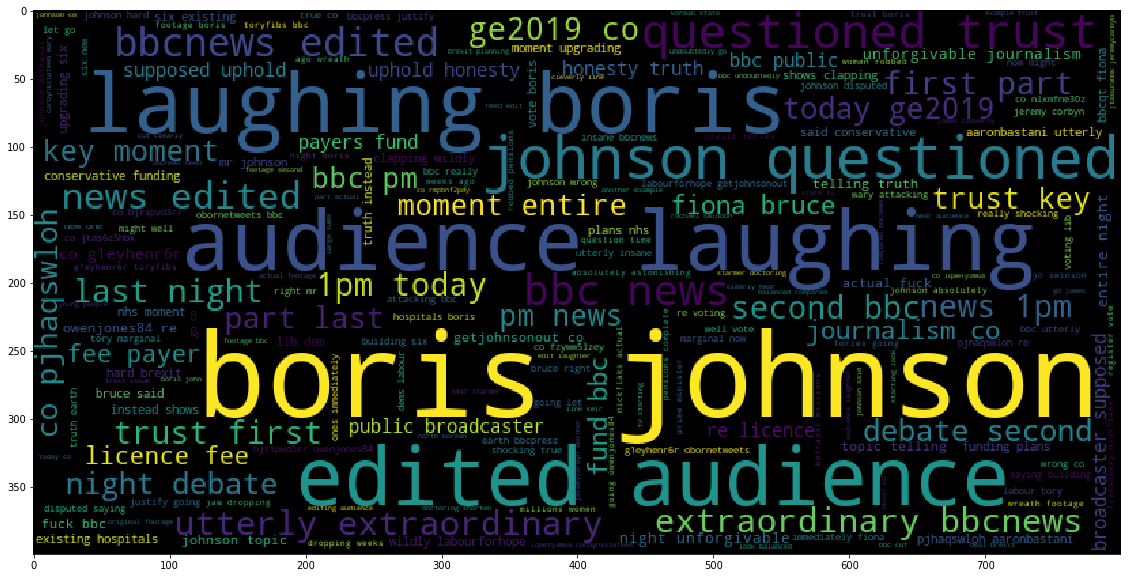

In [48]:
separator = " "
bj_wordcloud = separator.join(bj_stopwords)
bj_wordcloud = bj_wordcloud.replace('https',"")
# lower max_font_size
wordcloud = WordCloud(width=800, height=400).generate(bj_wordcloud.translate(table_p)) 

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("on")
plt.savefig('bj_word_cloud.png') # save as PNG file
plt.savefig('bj_word_cloud.pdf') # save as PDF file
plt.show()  # show in Jupyter notebook


Using TextBlob, calculate the polarity and subjectivity scores for each tweet in the 5K + 5K tweet corpus, and please answer the following questions.
1.	What are the average polarity and subjectivity scores for each keyword?
2.	Visualize the polarity and subjectivity score distributions using histograms, where X-axis is the score and Y-axis is the tweet count in the score bin. In total, there should be 4 histograms for this task.
3.	Based on the polarity scores, what are the most positive and negative tweets on each keyword? Why is the author happy/angry on the topic?

In [49]:
# Take the parsed list of tweets (tweet_list_brexit) and turn it into a single string per tweet
brexit_tweets = []
string = ""
for tweet in tweet_list_brexit:
    brexit_tweets.append(string.join([item for sublist in tweet for item in sublist])) # Join the list in list with a list comprehension

In [50]:
brex_sub_list = []
brex_pol_list = []
for s in brexit_tweets:
    tb = TextBlob(str(s))
    brex_sub_list.append(tb.sentiment.subjectivity)
    brex_pol_list.append(tb.sentiment.polarity)

In [51]:
print("Average Subjectivity: ",mean(brex_sub_list))
print("Average Polarity: ", mean(brex_pol_list))

Average Subjectivity:  0.45777069608768023
Average Polarity:  0.02312315172734414


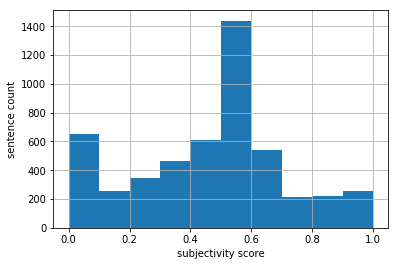

In [52]:
plt.hist(brex_sub_list, bins=10) #, normed=1, alpha=0.75)
plt.xlabel('subjectivity score')
plt.ylabel('sentence count')
plt.grid(True)
plt.savefig('brex_subjectivity.pdf')
plt.show()

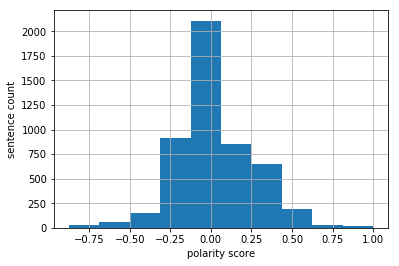

In [53]:
plt.hist(brex_pol_list, bins=10) #, normed=1, alpha=0.75)
plt.xlabel('polarity score')
plt.ylabel('sentence count')
plt.grid(True)
plt.savefig('brex_polarity.pdf')
plt.show()

### Most negative and positive Tweets about Brexit

In [54]:
max = [0,0]
min = [0,0]
for c, x in enumerate(brex_pol_list):
    if x > max[0]:
        max = [x,c]
    if x < min[0]:
        min = [x,c]

tb = TextBlob(str(brexit_tweets[max[1]]))
print(brexit_tweets[max[1]])
print(max[0])

RT @MichaelRosenYes: Until Corbyn tells me which way to vote on Brexit, I’m in pieces. I have no means to make up my own mind. He-e-e-lp!!!!
1.0


In [55]:
tb = TextBlob(str(brexit_tweets[min[1]]))
print(brexit_tweets[min[1]])
print(min[0])

@EmmaKennedy It's not going to happen. Swinson will support a Johnson govt if she can, and give these two reasons: (1) Lib Dems can mitigate worst aspects of Brexit, and (2) The Union: Johnson has promised not to grant #indyref2.

Stopping Brexit is not her priority.
-0.875


### Sentiment analysis of Boris Johnson Tweets

In [56]:
bj_tweets = []
string = ""
for tweet in tweet_list_boris_johnson:
    bj_tweets.append(string.join([item for sublist in tweet for item in sublist]))

In [57]:
bj_sub_list = []
bj_pol_list = []
for s in bj_tweets:
    tb = TextBlob(str(s))
    bj_sub_list.append(tb.sentiment.subjectivity)
    bj_pol_list.append(tb.sentiment.polarity)

In [58]:
print("Average Subjectivity: ",mean(bj_sub_list))
print("Average Polarity: ", mean(bj_pol_list))

Average Subjectivity:  0.47158841721841954
Average Polarity:  0.03324636912858966


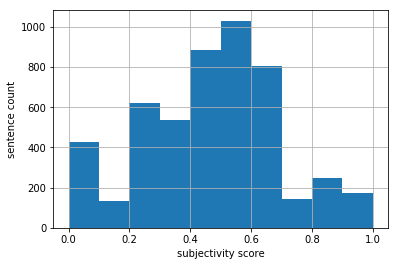

In [59]:
plt.hist(bj_sub_list, bins=10) #, normed=1, alpha=0.75)
plt.xlabel('subjectivity score')
plt.ylabel('sentence count')
plt.grid(True)
plt.savefig('bj_subjectivity.pdf')
plt.show()

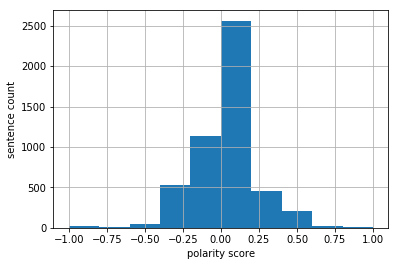

In [60]:
plt.hist(bj_pol_list, bins=10) #, normed=1, alpha=0.75)
plt.xlabel('polarity score')
plt.ylabel('sentence count')
plt.grid(True)
plt.savefig('bj_polarity.pdf')
plt.show()

### Most negative and positive Tweets about Brexit

In [61]:
max = [0,0]
min = [0,0]
for c, x in enumerate(bj_pol_list):
    if x > max[0]:
        max = [x,c]
    if x < min[0]:
        min = [x,c]

tb = TextBlob(str(bj_tweets[max[1]]))
print(bj_tweets[max[1]])
print(max[0])

@smartysue Who did best on #bbcqt... ?

Jeremy Corbyn 12%
Nicola Sturgeon 9%
Jo Swinson 27%
Boris Johnson 52%

YouGov,
Polled 1,342 on 22 Nov, between 6pm-7pm.RT @CrankyOutrider: @smartysue Who did best on #bbcqt... ?

Jeremy Corbyn 12%
Nicola Sturgeon 9%
Jo Swinson 27%
Boris Johnson 52%

YouGov,…
1.0


In [62]:
tb = TextBlob(str(bj_tweets[min[1]]))
print(bj_tweets[min[1]])
print(min[0])

On Boris Johnson

"All an Eton education teaches you, is to tell outrageous lies in a posh accent, with some Latin words thrown in"

#GE2019 https://t.co/pIEHGJB0zTRT @Doozy_45: On Boris Johnson

"All an Eton education teaches you, is to tell outrageous lies in a posh accent, with some Latin words thro…
-1.0
